In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
! pip install geopandas
import geopandas as gpd
import numpy as np
%config InlineBackend.figure_format = 'retina'

from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
! pip install hydrofunctions
import hydrofunctions as hf
import matplotlib.font_manager as fm
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
fm.fontManager.ttflist += fm.createFontList(['thsarabunnew-webfont.ttf'])
matplotlib.rc('font', family='TH Sarabun New')


     |████████████████████████████████| 1.0 MB 6.6 MB/s 
     |████████████████████████████████| 6.3 MB 37.3 MB/s 
     |████████████████████████████████| 16.7 MB 291 kB/s 
     |████████████████████████████████| 220 kB 6.7 MB/s 
--2022-03-04 19:06:39--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2022-03-04 19:06:39--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


## Import information about study sites

In [ ]:
# import shapefile of study sites and site info
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/california_site_list.zip'
gages = gpd.read_file(loc).to_crs(epsg = 4326)
# import basin outlines
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/california_site_watershed_boundaries.zip'
basin_outlines = gpd.read_file(loc).to_crs(epsg = 4326)
gage_info = gages.merge(basin_outlines,left_on='SITE_NO',
            right_on='SITE_NO')
# US state map from https://catalog.data.gov/dataset/tiger-line-shapefile-2017-nation-u-s-current-state-and-equivalent-national
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/state_outline.zip'
state_outline = gpd.read_file(loc).to_crs(epsg = 4326)
state_outline = state_outline[state_outline.STUSPS=='CA']

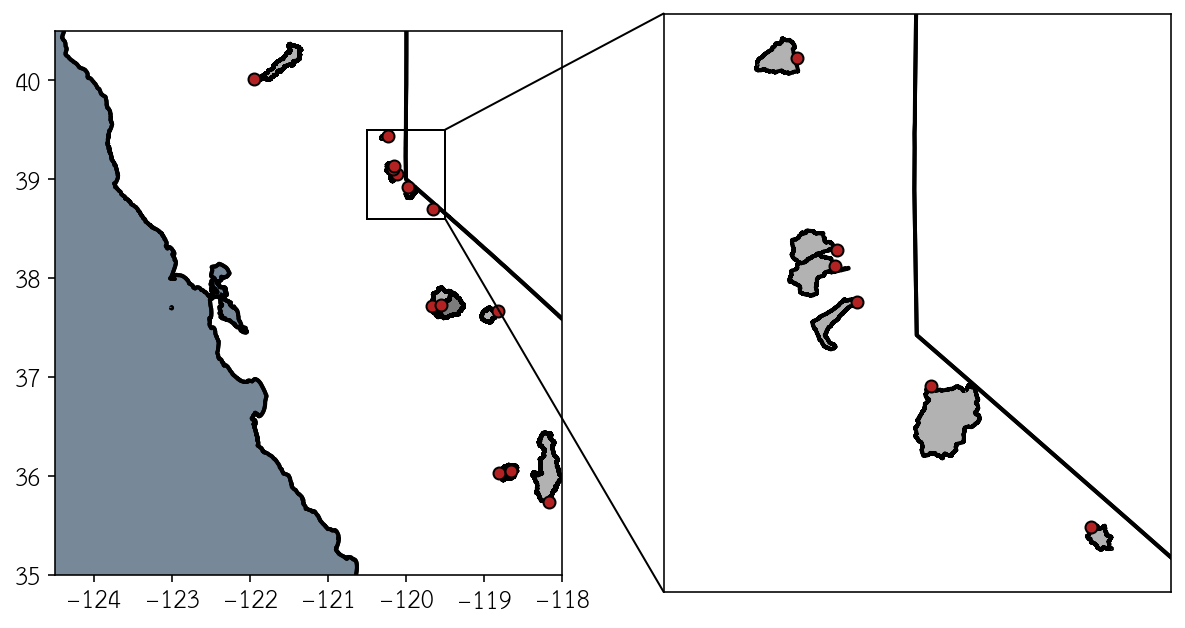

In [ ]:
# make a simiple map of the study area
%matplotlib inline
plt.rcParams.update({'font.size': 12})
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch

fig,axs = plt.subplots(1,2,figsize=(10,10))

minx, maxx = (-120.5,-119.5)
miny, maxy = (38.6,39.5)

ax = axs[0]
ax.axvspan(-130,-120,facecolor='lightslategray')#,alpha = 0.5)
ax.axhspan(30,35,facecolor='lightslategray')#,alpha=0.5)
state_outline.boundary.plot(ax=ax,lw=2,edgecolor = 'k',facecolor = 'white')
state_outline.boundary.plot(ax=ax,lw=2,edgecolor = 'k')
basin_outlines.boundary.plot(ax=ax,facecolor='k',alpha=0.3)
basin_outlines.boundary.plot(ax=ax,lw=2,edgecolor='k')
gages.plot(ax=ax,marker='o',c='firebrick',zorder = 100,edgecolor = 'k')
ax.set_xlim(-124.5,-118)
ax.set_ylim(35,40.5)

# Create a Rectangle patch
rect = patches.Rectangle((minx,miny), maxx-minx, maxy-miny, linewidth=1, 
                         edgecolor='k', facecolor='none',zorder = 100)
# Add the patch to the Axes
ax.add_patch(rect)




ax = axs[1]
state_outline.boundary.plot(ax=ax,lw=2,edgecolor = 'k')
state_outline.boundary.plot(ax=ax,lw=2,edgecolor = 'k')
basin_outlines.boundary.plot(ax=ax,facecolor='k',alpha=0.3)
basin_outlines.boundary.plot(ax=ax,lw=2,edgecolor='k')
gages.plot(ax=ax,marker='o',c='firebrick',zorder = 100,edgecolor = 'k')
ax.set_xlim(minx,maxx)
ax.set_ylim(miny,maxy)
ax.set_xticks([])
ax.set_yticks([])

con = ConnectionPatch(xyA=(maxx,maxy), xyB=(minx,maxy), coordsA="data", coordsB="data",
                      axesA=axs[0], axesB=axs[1], color="k")
ax.add_artist(con)
con = ConnectionPatch(xyA=(maxx,miny), xyB=(minx,miny), coordsA="data", coordsB="data",
                      axesA=axs[0], axesB=axs[1], color="k")
ax.add_artist(con)

## Import Snow Water Equivalent (SWE) data from SNODAS
https://nsidc.org/data/g02158#:~:text=SNODAS%20is%20a%20modeling%20and,support%20hydrologic%20modeling%20and%20analysis. 

In [ ]:
# import processed SNODAS data, mean for each basin on all dates
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/snodas_basin_data1.csv'
snodas_data = pd.read_csv(loc)
snodas_data['date'] = pd.to_datetime(snodas_data.date)
snodas_data = snodas_data.set_index('date').sort_index()

In [ ]:
# process data for each study gage from csv format into a dataframe 
# with one column for each site

swe_data = ''

for gage in snodas_data.sitenum.drop_duplicates():
  snowdat = snodas_data[snodas_data.sitenum==gage].drop(columns='sitenum')
  snowdat['wy'] = np.where(snowdat.index.month.isin([10,11,12]),
                           snowdat.index.year+1,snowdat.index.year)    
  if len(swe_data)==0:
    swe_data = snowdat[['swe']].rename(columns={'swe':gage}).dropna()
  else:
    swe_data = swe_data.merge(snowdat[['swe']].rename(columns={'swe':gage}).dropna(),
                              left_index=True,right_index=True).drop_duplicates()

## Import streamflow data from NWIS
https://waterdata.usgs.gov/nwis/rt

In [ ]:
# get spring streamflow data from NWIS

springflow = {} # total spring streamflow
years = list(range(2001,2022))

for gage in gages.SITE_NO.values:
  flow_data = hf.NWIS(gage, 'dv', start_date = '2000-10-01',
                      end_date = '2021-10-01').df('00060')
  flow_data = flow_data*12**3*2.54**3/100**3*60*60*24
  # convert to depth (m/d)
  area = (gage_info[gage_info.SITE_NO==gage].SQMI*2.59*1000000).values[0] # are in m2
  flow_data = flow_data/area
  # convert to mm/day
  flow_data = flow_data*1000
  
  
  spring_streamflow = []
  for yr in years:
    try:
      spring_streamflow.append(sum(flow_data.loc[str(yr)+'-04-01':str(yr)+'-09-01'].values)[0])
    except:
      spring_streamflow.append(np.nan)
  springflow[gage] = spring_streamflow

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10336780&startDT=2000-10-01&endDT=2021-10-01
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10336645&startDT=2000-10-01&endDT=2021-10-01
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10336660&startDT=2000-10-01&endDT=2021-10-01
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10336676&startDT=2000-10-01&endDT=2021-10-01
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10343500&startDT=2000-10-01&endDT=2021-10-01
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10308783&startDT=2000-10-01&endDT=2021-10-01
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=11383500&startDT=2000-10-01&endDT=2021-10-01
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=11189500&star

## Examine relationship between April 1 SWE and spring runoff

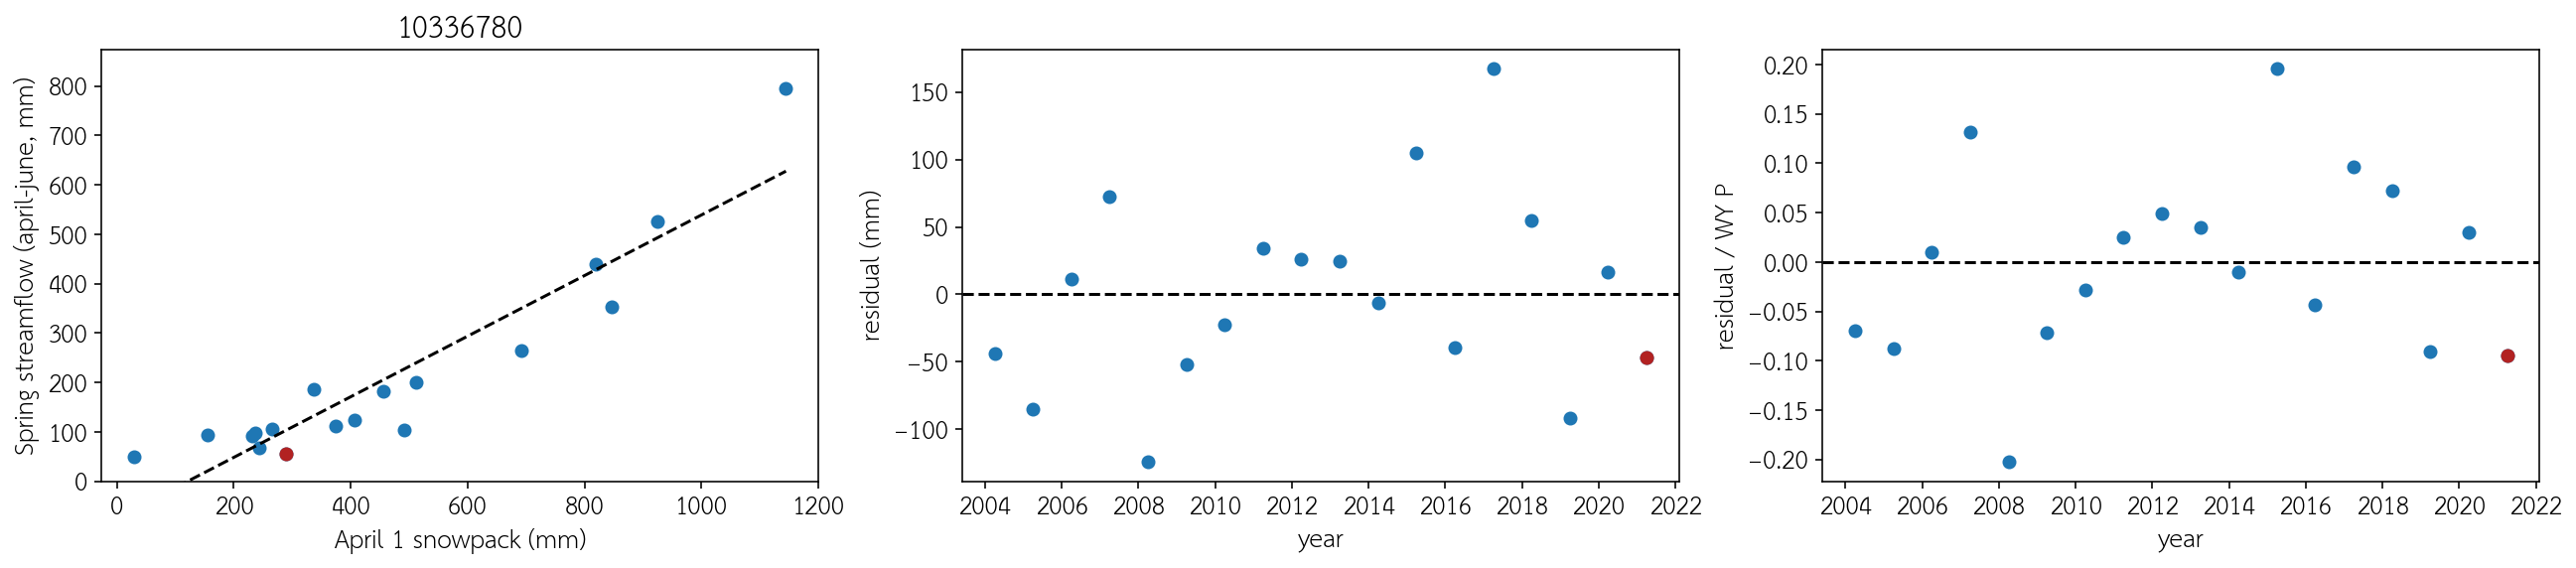

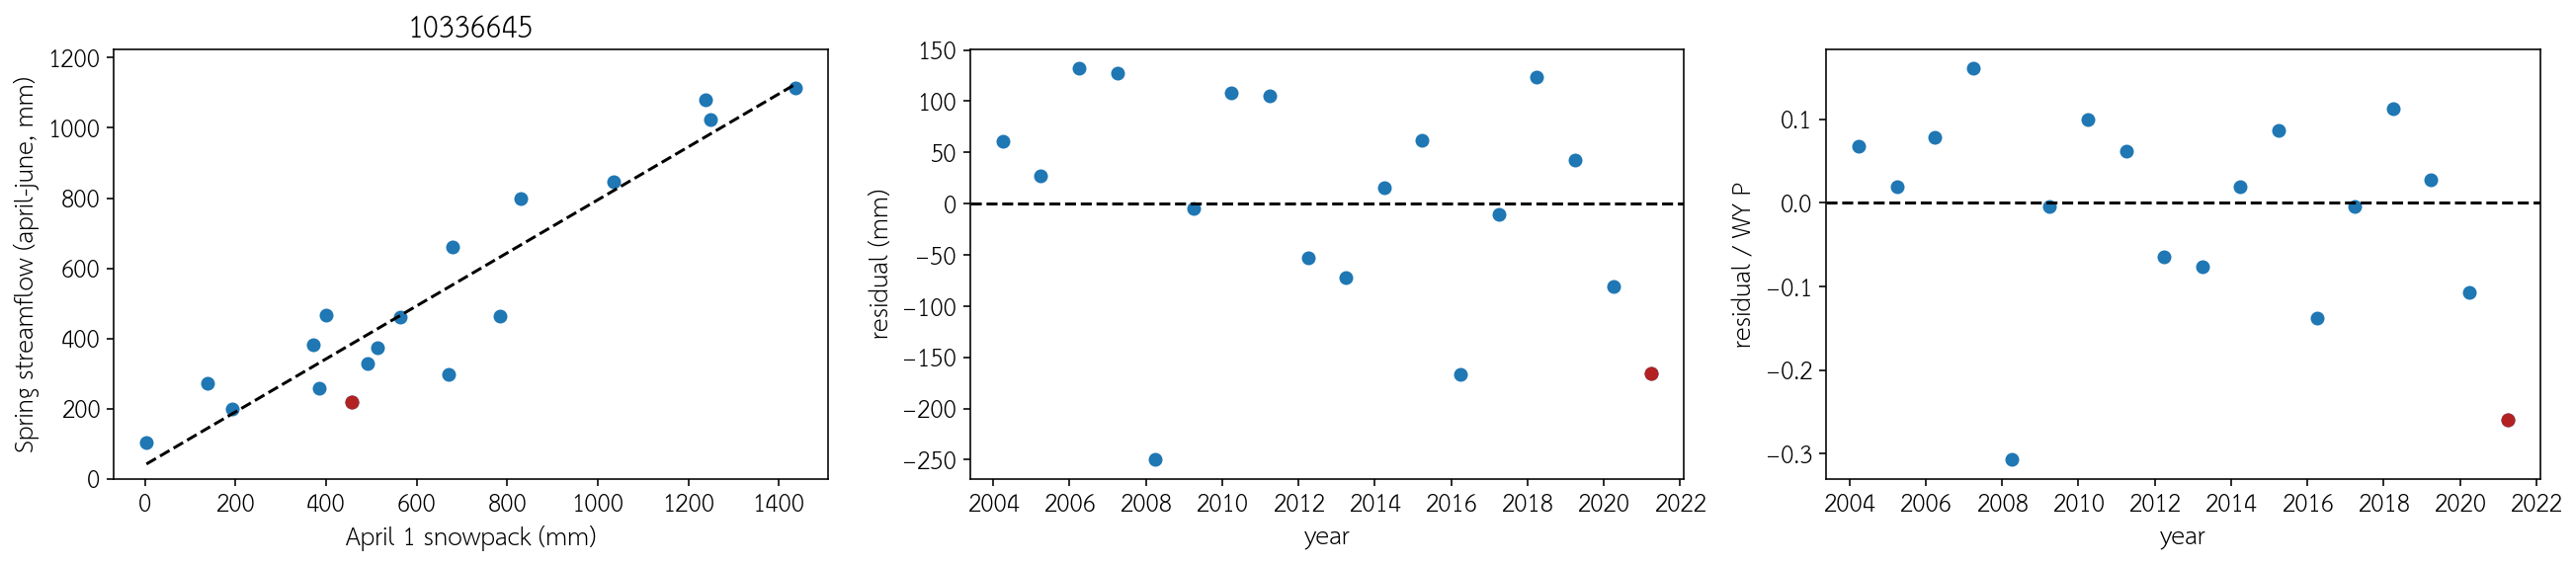

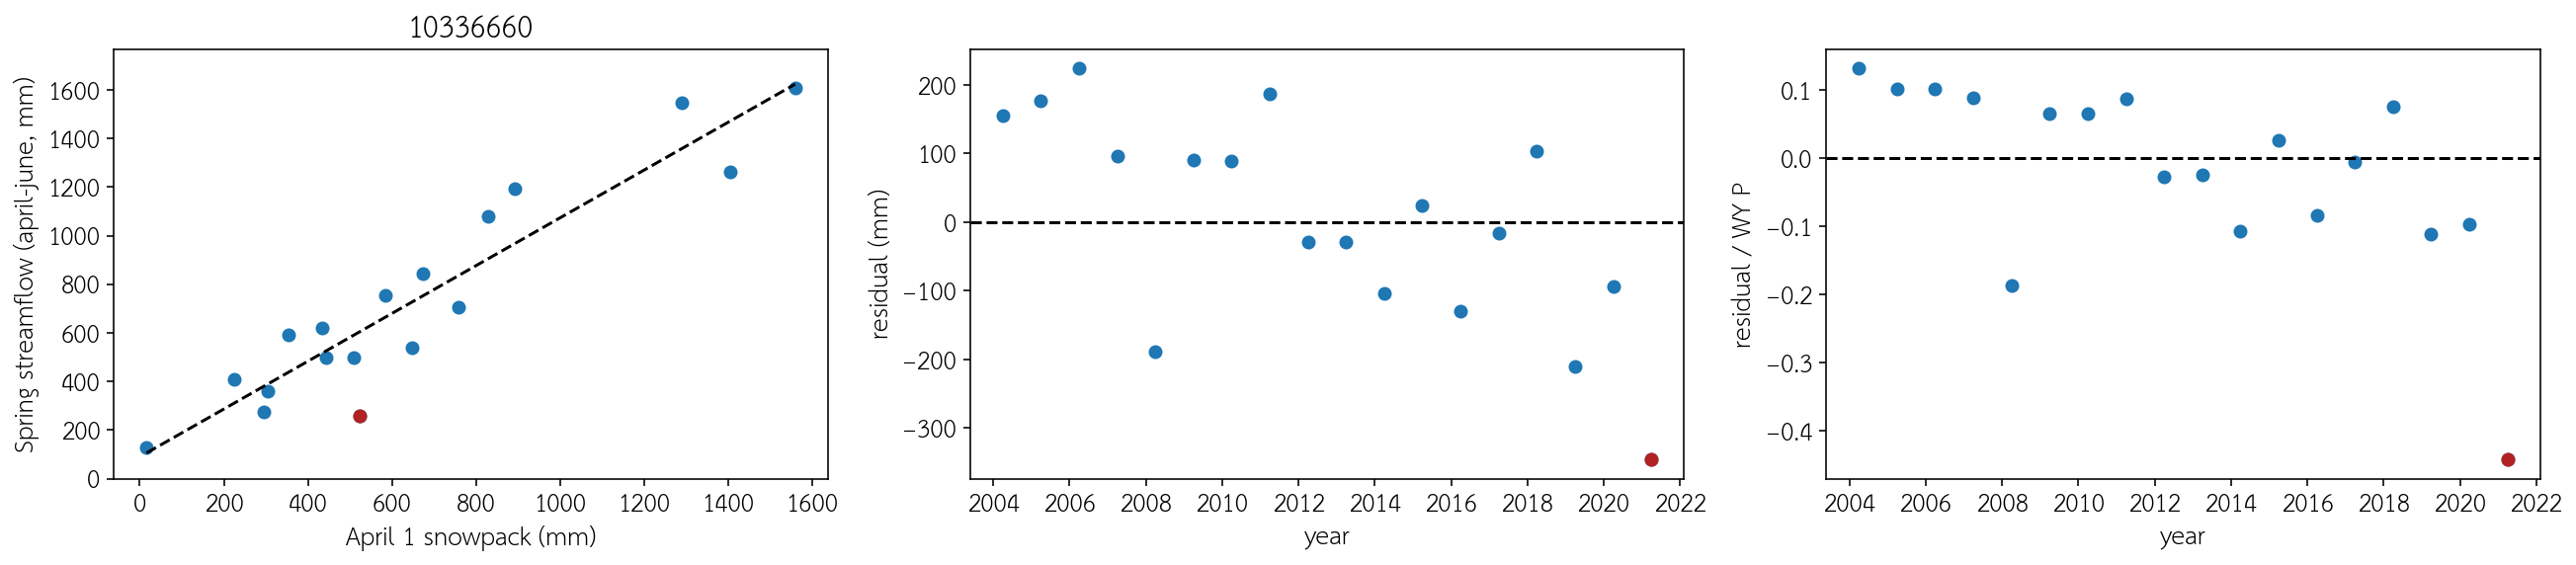

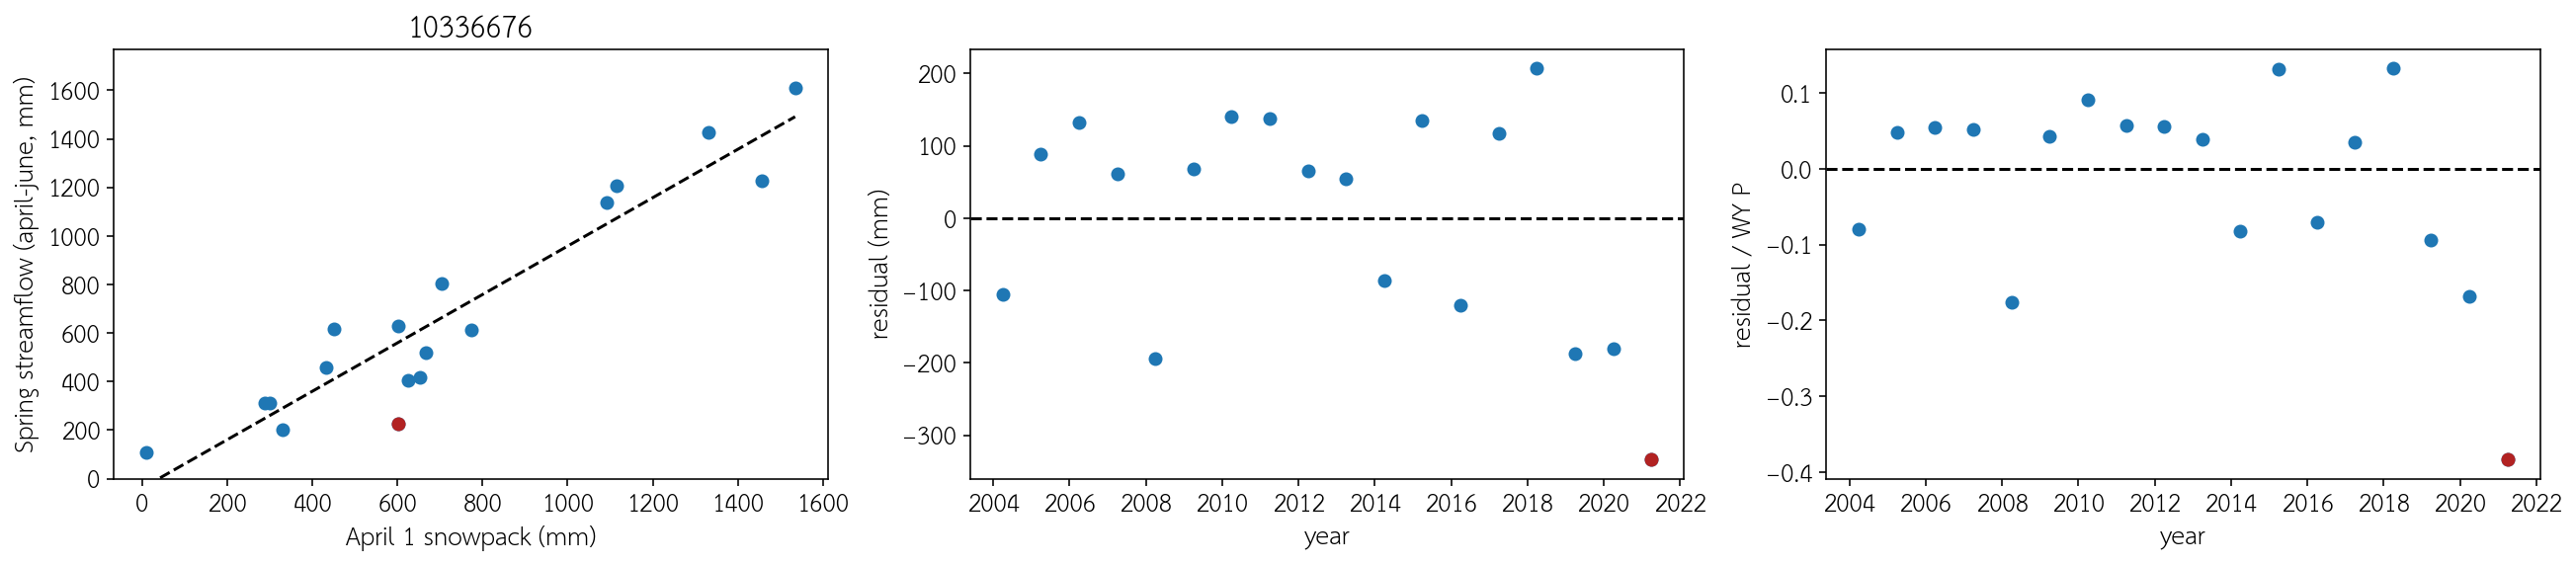

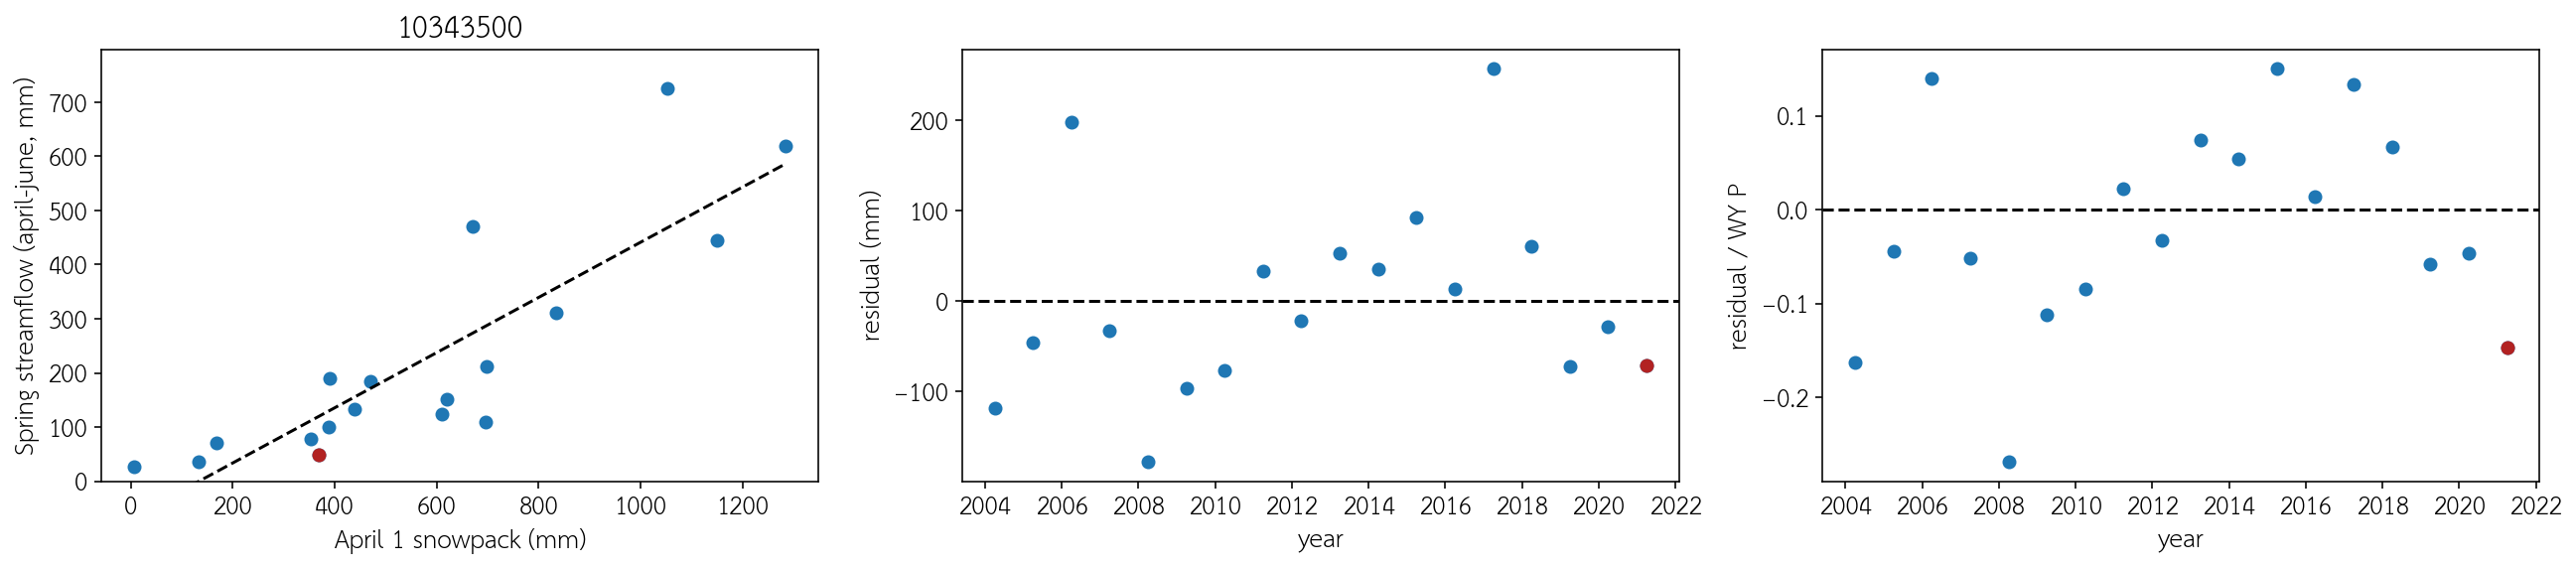

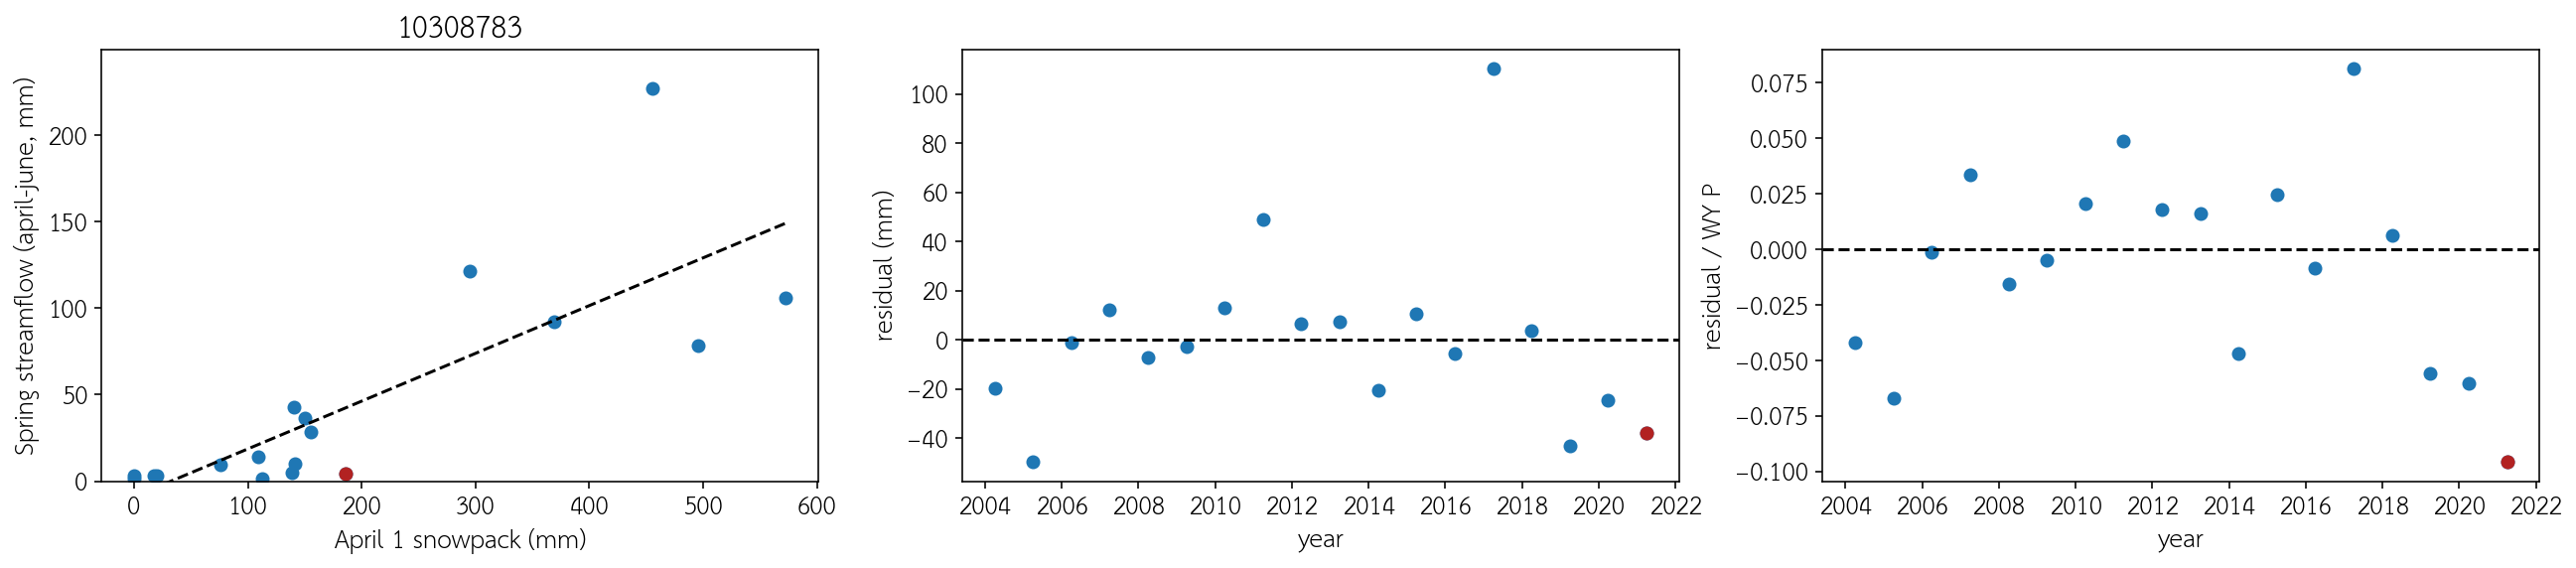

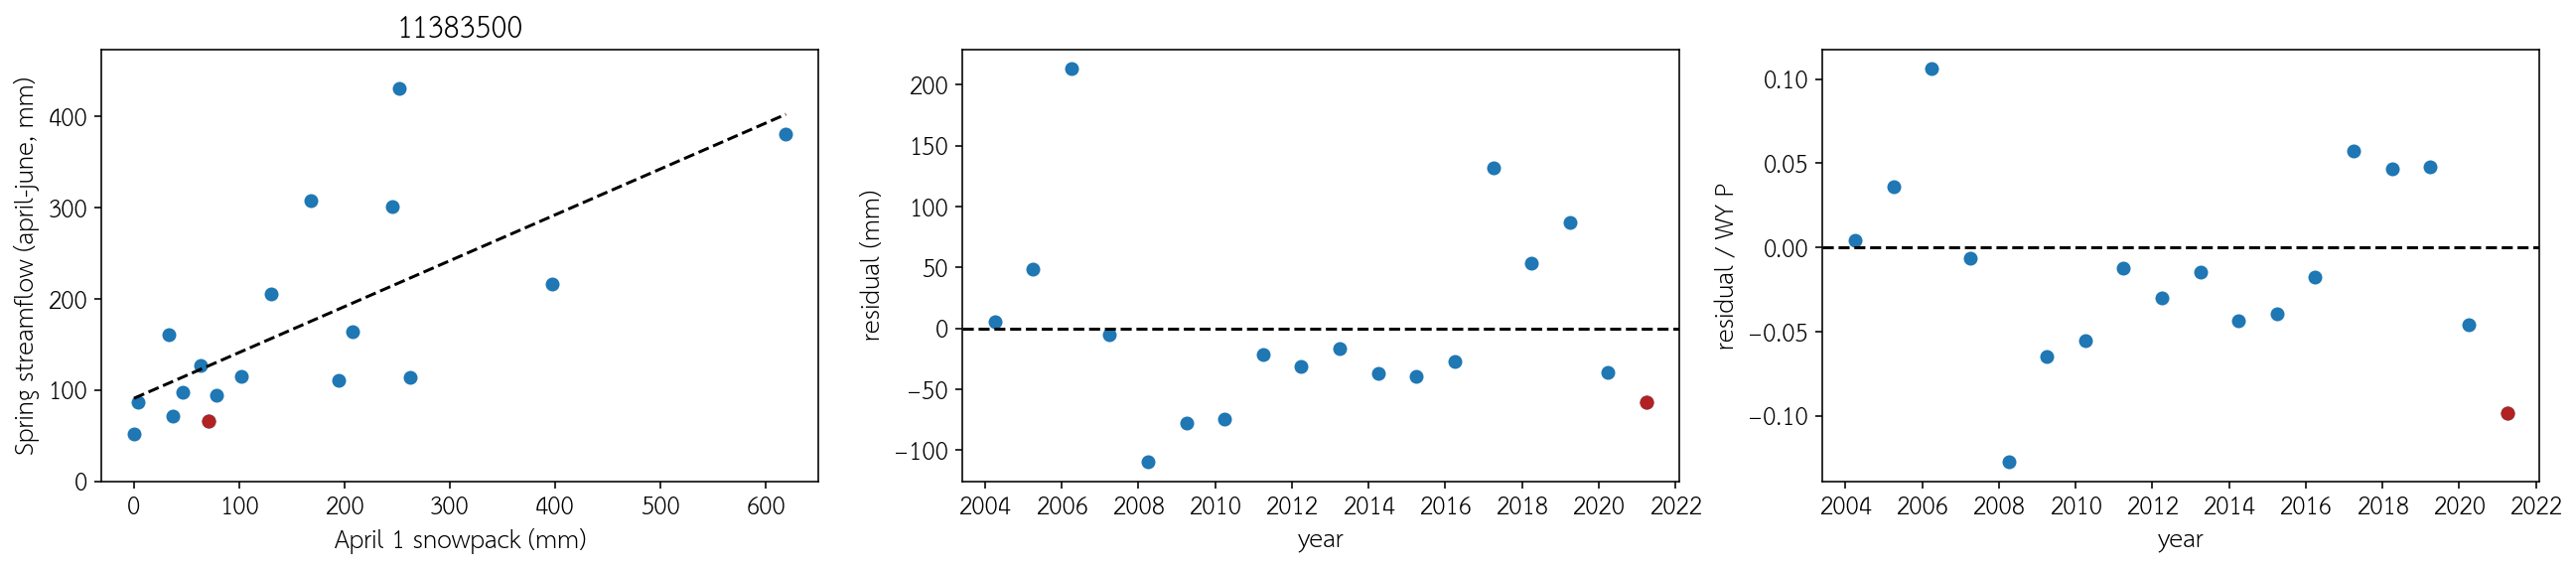

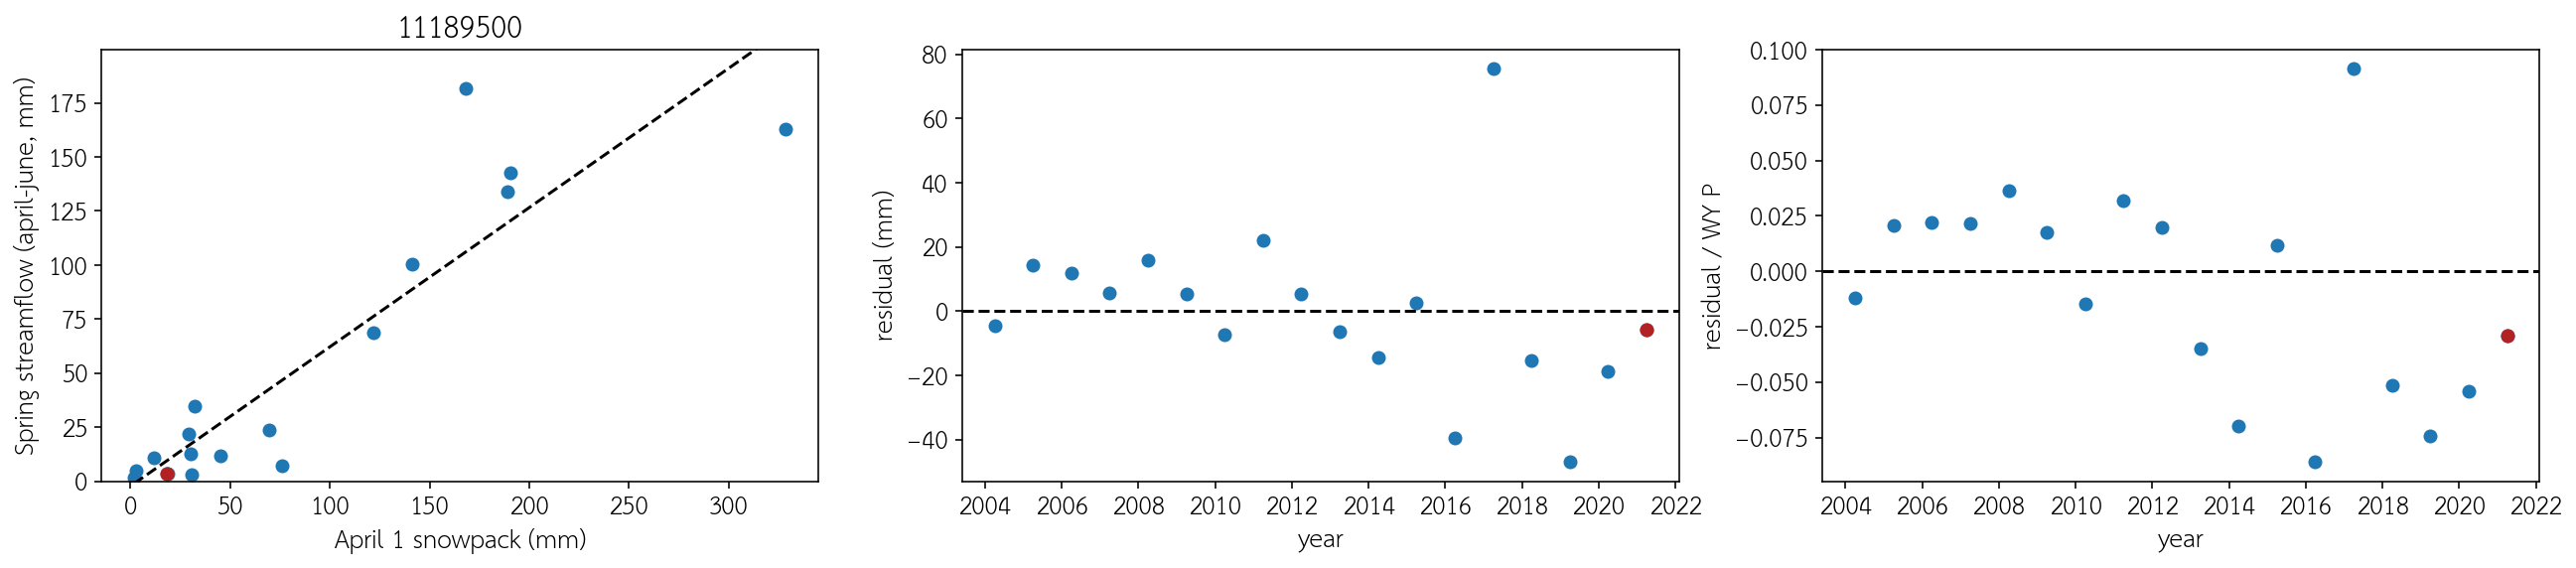

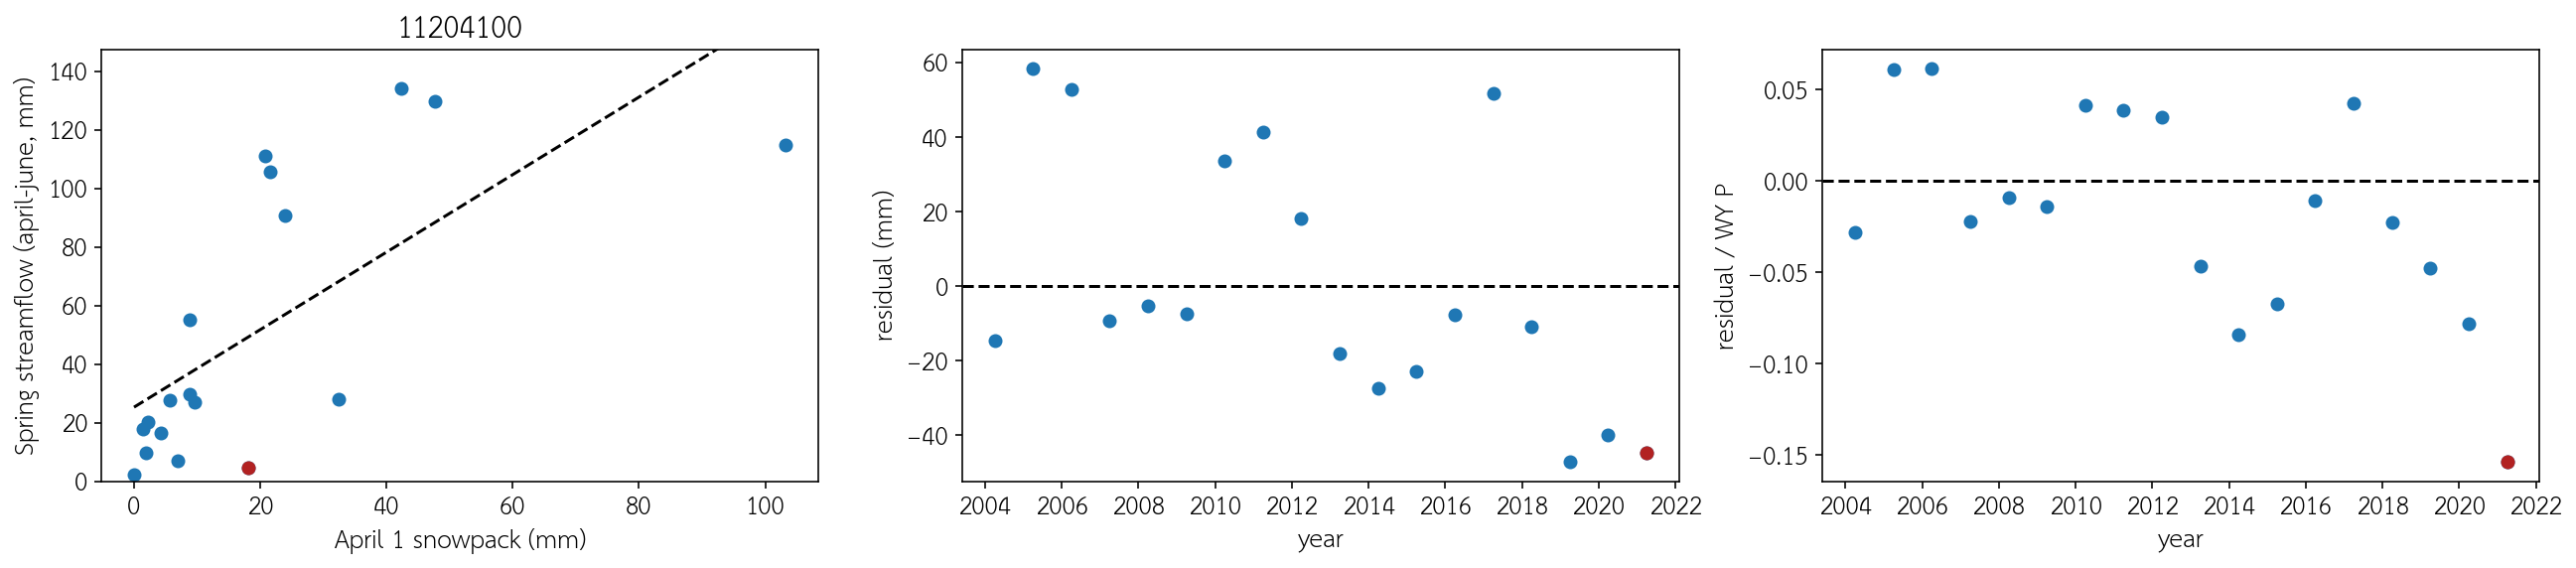

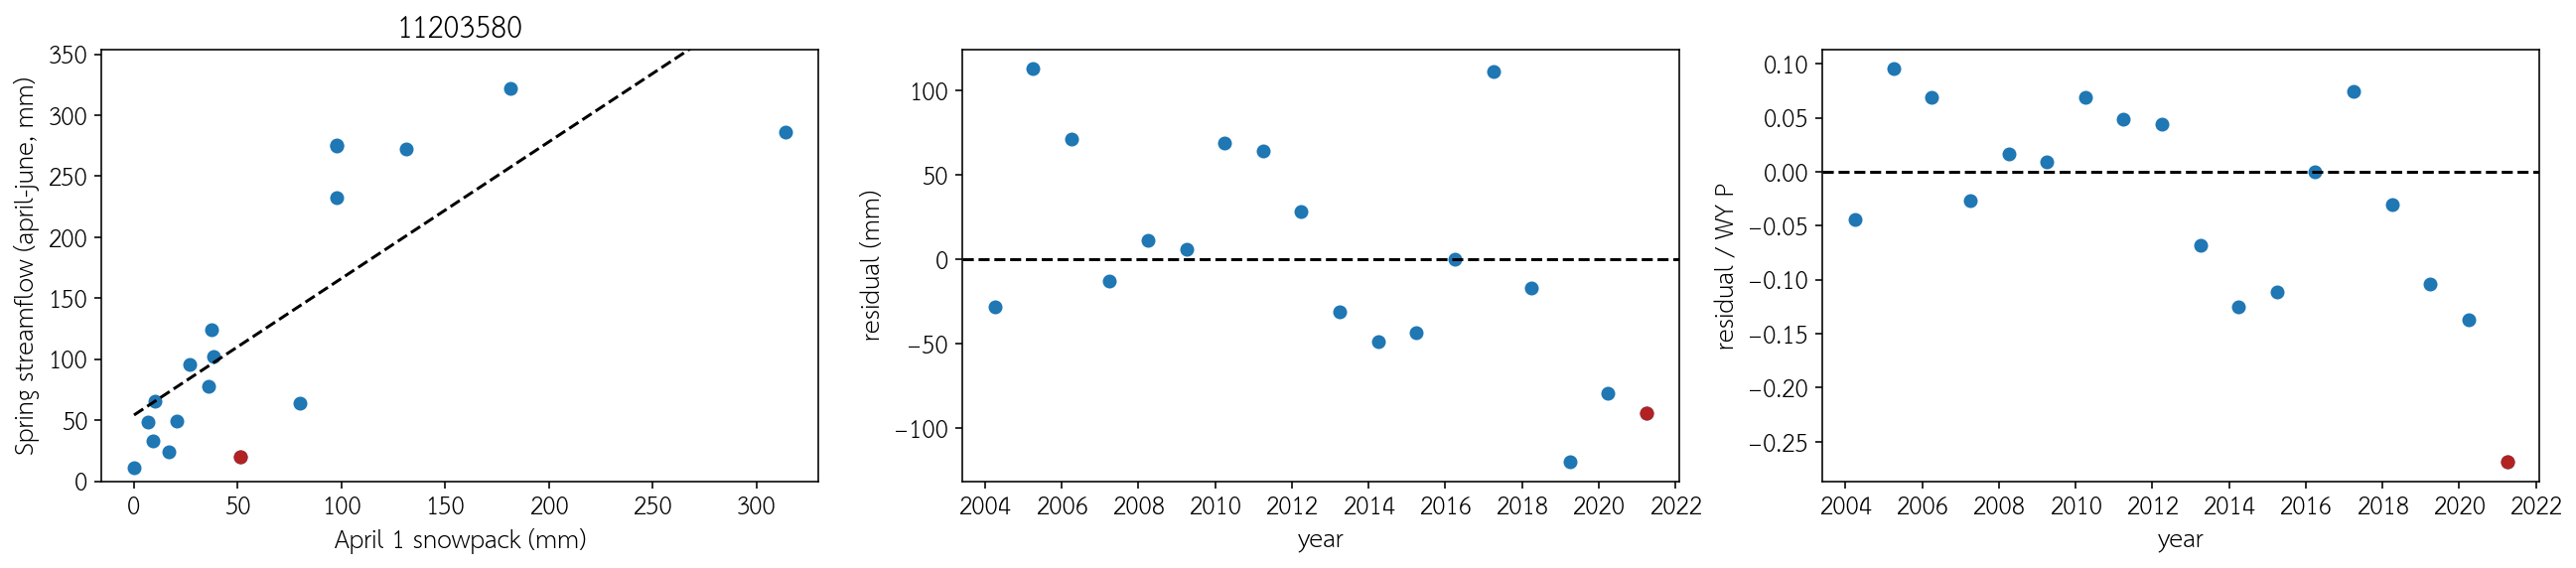

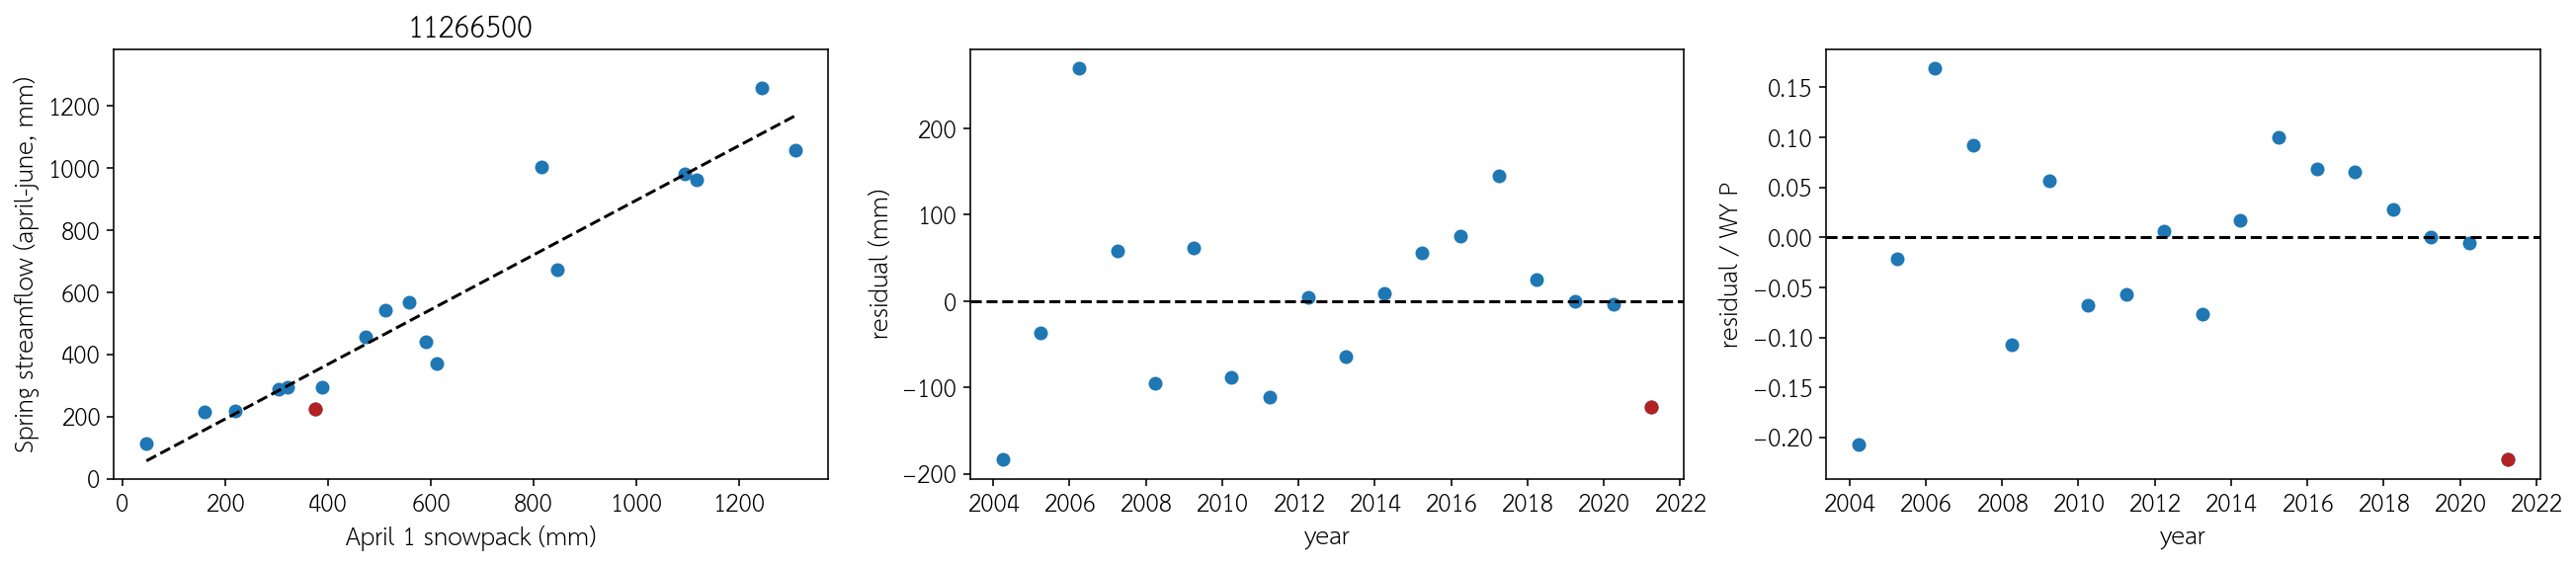

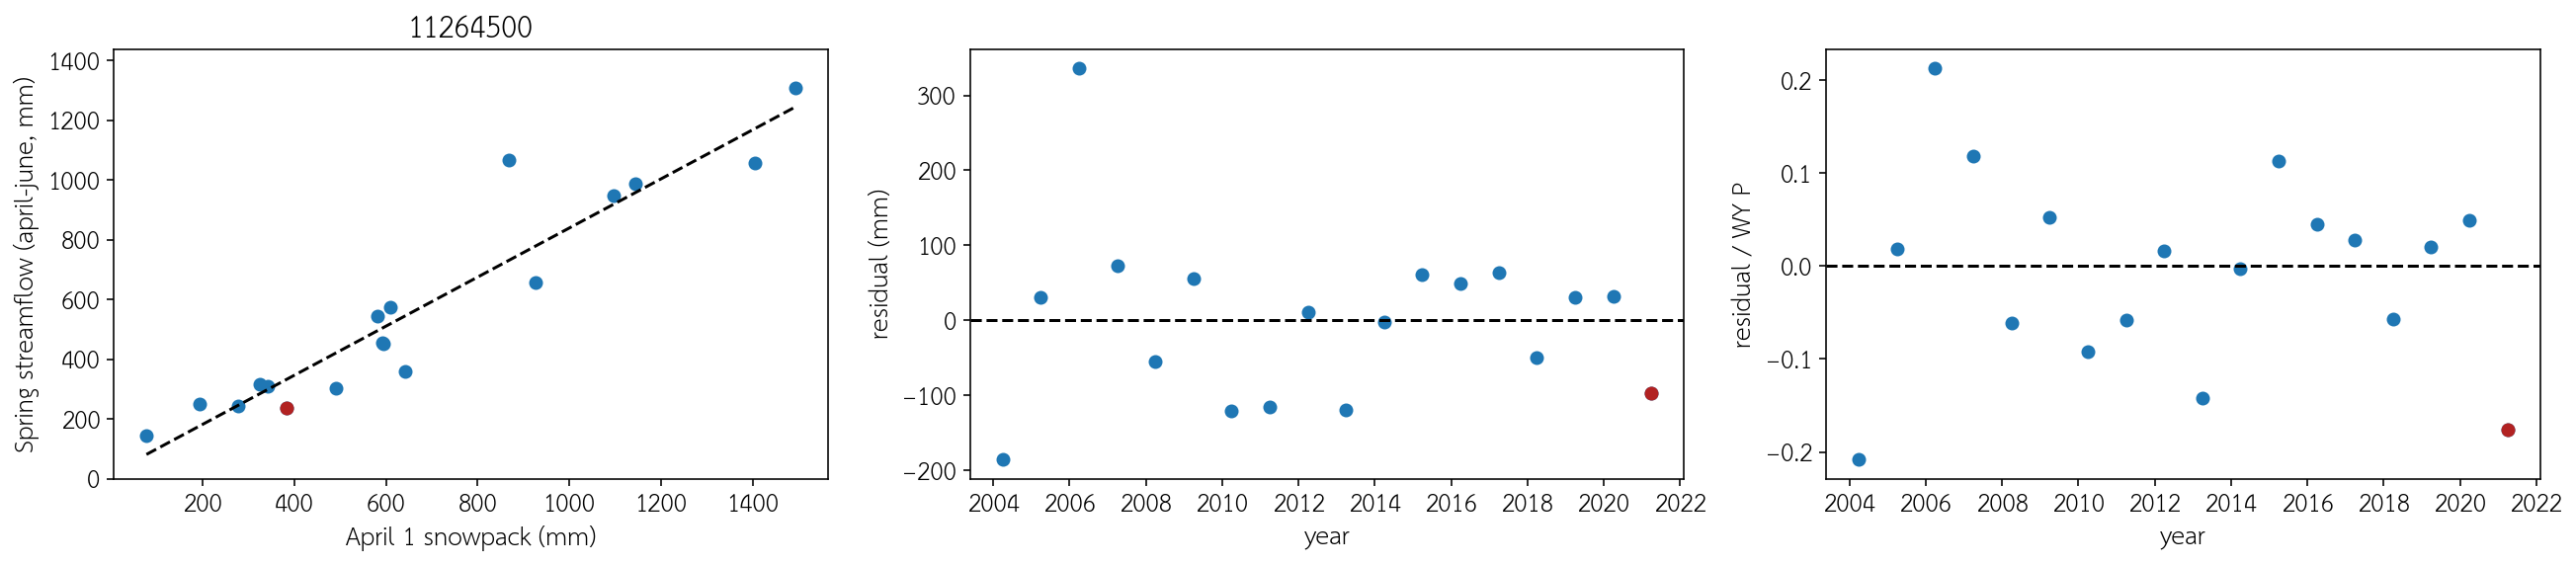

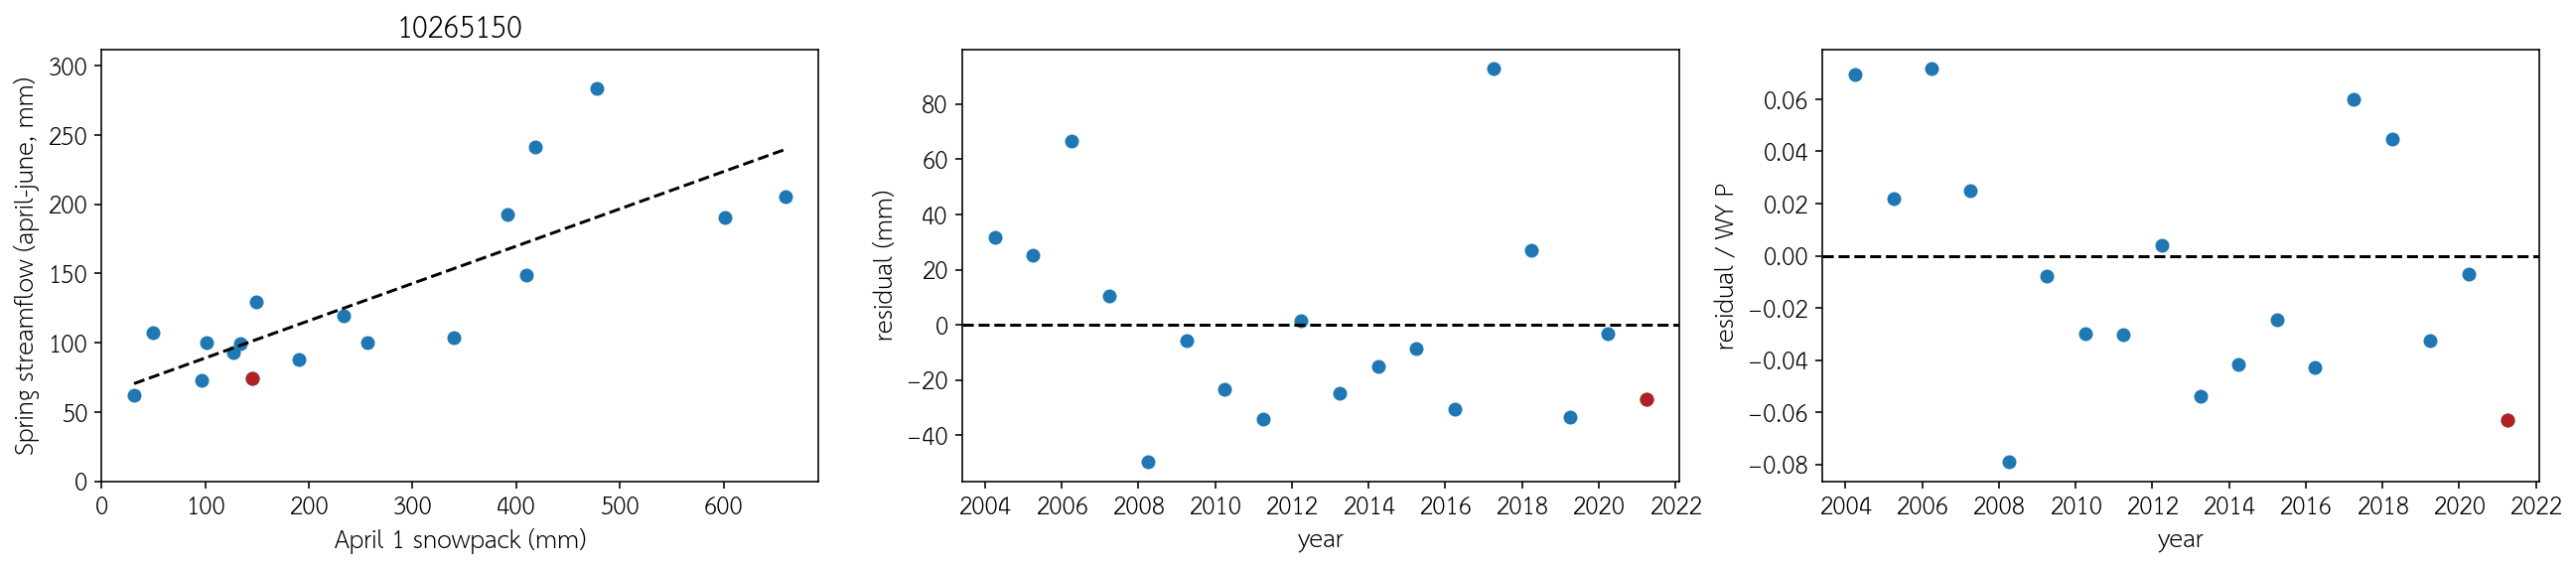

In [ ]:
def func(x,a,b):
  return a*x+b
from scipy import stats

# grab April 1 data from each year for each site
snow_data = swe_data[(swe_data.index.month==4) &
                     (swe_data.index.day==1)]


residuals_snodas = {} # residuals in SWE-Q relationship
snow_data_perc = {} # SWE percentiles
springflow_perc = {} # spring Q percentiles

Pdata=''
for gage in gages.SITE_NO.values:
  
  fig,axs = plt.subplots(1,3,figsize = (22,4))
  yvals =  springflow[gage][-1*len(snow_data):]
  snow_mm = snow_data[int(gage)]
  mask = (np.isfinite(yvals)) & (np.isfinite(snow_mm.values))

  # get percentiles (I don't think this is used)
  springflow_perc[gage] = [stats.percentileofscore(yvals, a, 'rank') for a in yvals]
  snow_perc = [stats.percentileofscore(snow_mm, a, 'rank') for a in snow_mm]
  snow_data_perc[gage] = snow_perc

  # mask by non-inf and non-nan
  snow_mm = snow_mm.values[mask]
  yvals = np.array(yvals)[mask]

  # fit a relationship between SWE and Q
  popt, pcov = curve_fit(func, snow_mm, yvals)
  residuals = np.array(yvals) - func(np.array(snow_mm), *popt)
  
  # plot the results
  ax = axs[0]
  ax.scatter(snow_mm,yvals)
  ax.set_xlabel('April 1 snowpack (mm)')
  ax.set_ylabel('Spring streamflow (april-june, mm)')
  ax.scatter(snow_mm[-1:],springflow[gage][-1:],
              c='firebrick')
  xvals = np.linspace(np.nanmin(snow_mm),np.nanmax(snow_mm))
  ax.plot(xvals,func(xvals,*popt),c='k',ls='--')

  ax.set_title(gage)
  ax.set_ylim(0,np.nanmax(springflow[gage])*1.1)

  ax = axs[1]
  ax.scatter(snow_data.index[mask],residuals)#/snow_mm)
  ax.set_xlabel('year')
  ax.set_ylabel('residual (mm)')
  # ax.set_ylim(-1,1)
  ax.axhline(0,ls='--',c='k')
  ax.scatter(snow_data.index.values[-1:],residuals[-1:]#/snow_mm[-1:]
             ,c='firebrick')
  residuals_snodas[gage] = np.where(np.isfinite(residuals),#/snow_mm),
                                    residuals,#/snow_mm,
                                    100)
  
  ax = axs[2]
  loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/MODIS_and_PRISM_data/modis_data_'
  pdata = pd.read_csv(loc+str(gage)+'.csv')
  pdata = pdata.groupby('wy').sum().P.to_frame().rename(columns={'P':gage})
  if len(Pdata)==0:
    Pdata = pdata
  else:
    Pdata = Pdata.merge(pdata,left_index=True,right_index=True)
  ax.scatter(snow_data.index[mask],residuals/Pdata[gage].values[-len(snow_data):])
  ax.set_xlabel('year')
  ax.set_ylabel('residual / WY P')
  # ax.set_ylim(-1,1)
  ax.axhline(0,ls='--',c='k')
  ax.scatter(snow_data.index.values[-1:],residuals[-1:]/Pdata[gage].values[-1:]
             ,c='firebrick')

In [ ]:
# save residuals so they're all the same length and can be put into a dataframe

maxlen = 0
for key in residuals_snodas.keys():
  if len(residuals_snodas[key])>maxlen:
    maxlen = len(residuals_snodas[key])

for key in residuals_snodas.keys():
  if len(residuals_snodas[key])<maxlen:
    residuals_snodas[key] = list(residuals_snodas[key]) + [np.nan]*(maxlen-len(residuals_snodas[key]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


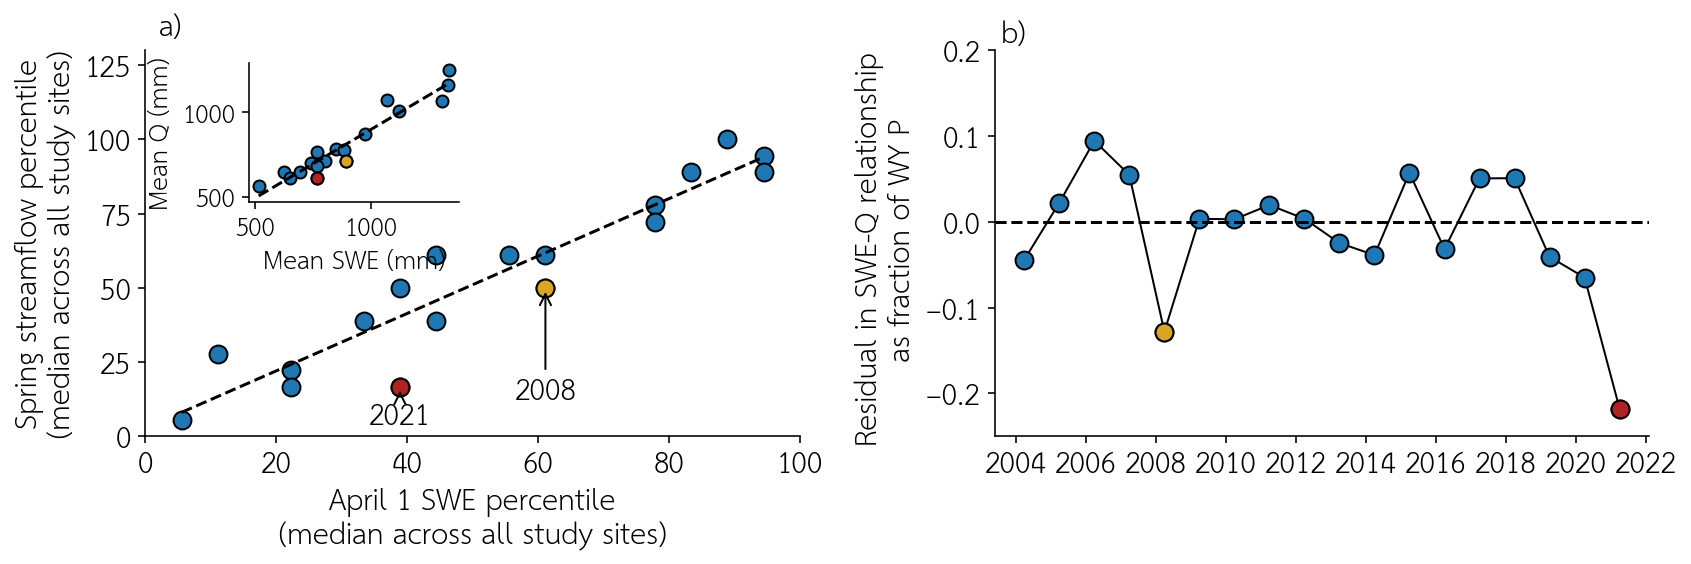

In [ ]:
# make publication figure with aggregated data across all study sites

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.rcParams.update({'font.size': 14})
def func(x,a,b):
  return a*x+b

snow_data_perc = pd.DataFrame.from_dict(snow_data_perc).median(axis=1)
springflow_perc_all = pd.DataFrame.from_dict(springflow_perc).median(axis=1)
snow_data_all = snow_data.mean(axis=1) 
springflow_all = pd.DataFrame.from_dict(springflow).mean(axis=1)
residuals_all = pd.DataFrame.from_dict(residuals_snodas).mean(axis=1)
residuals_all = residuals_all.values/Pdata.mean(axis=1).iloc[-len(residuals_all):].values
  
fig,axs = plt.subplots(1,2,figsize = (12,4),
                       )
snow_mm = snow_data_perc#snow_data_all
yvals =  springflow_perc_all#springflow_all[-1*len(snow_mm):]

popt, pcov = curve_fit(func, snow_mm, yvals)
residuals = np.array(yvals) - func(np.array(snow_mm), *popt)

popt1, pcov1 = curve_fit(func, snow_data_all, springflow_all[-1*len(snow_mm):])
residuals1 = np.array(springflow_all[-1*len(snow_mm):]) - func(np.array(snow_data_all), *popt1)

size=80
ax = axs[0]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.scatter(snow_mm,yvals,s=size,edgecolor = 'k')
ax.set_xlabel('April 1 SWE percentile\n(median across all study sites)')
ax.set_ylabel('Spring streamflow percentile\n(median across all study sites)')

colors = ['firebrick','goldenrod']
j=0
for i in ([2021,2008]):
  ax.annotate(str(i), xy=(snow_mm[17-2021+i:17-2021+i+1],yvals[17-2021+i:17-2021+i+1]),
              xytext=(snow_mm[17-2021+i:17-2021+i+1], yvals[17-2021+i:17-2021+i+1]/4) , 
            horizontalalignment="center",arrowprops=dict(arrowstyle='->',lw=1)
            )
  ax.scatter(snow_mm[17-2021+i:17-2021+i+1],yvals[17-2021+i:17-2021+i+1],
            c=colors[j],label='2021',s=size,edgecolor = 'k')
  j+=1
# ax.legend(loc='upper left',frameon=False)
xvals = np.linspace(np.nanmin(snow_mm),np.nanmax(snow_mm))
ax.plot(xvals,func(xvals,*popt),c='k',ls='--')
ax.set_xlim(0,100)
ax.set_ylim(0,130)#np.nanmax(springflow_all)*1.1)


ax = inset_axes(ax, width="40%", height="40%", loc=4,
                  bbox_to_anchor=(-.3,0.57,0.8,0.9),
                  bbox_transform=ax.transAxes)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Mean Q (mm)',fontsize = 12)
ax.set_xlabel('Mean SWE (mm)', fontsize = 12)
ax.scatter(snow_data_all,springflow_all[-1*len(snow_mm):]
           ,edgecolor = 'k')
ax.scatter(snow_data_all[-1:],springflow_all[-1:]
           ,edgecolor = 'k',c='firebrick')
ax.scatter(snow_data_all[4:5],(springflow_all[-1*len(snow_mm):])[4:5]
           ,edgecolor = 'k',c='goldenrod')
xvals = np.linspace(np.nanmin(snow_data_all),np.nanmax(snow_data_all))
ax.plot(xvals,func(xvals,*popt1),c='k',ls='--')
ax.set_xticklabels([0,500,1000],fontsize = 12)
ax.set_yticklabels([0,500,1000],fontsize = 12)


ax = axs[1]
ax.plot(snow_data.index,residuals_all,c='k',lw=1,zorder = -1)
ax.scatter(snow_data.index,residuals_all,s=size,edgecolor = 'k')
ax.set_ylim(-.25,.2)
ax.set_ylabel('Residual in SWE-Q relationship \n as fraction of WY P')
ax.axhline(0,ls='--',c='k')
j=0
for i in [2021,2008]:
  if i==2021:
    x = snow_data.index.values[-1:]
    y=residuals_all[-1:]
  else:
    x = snow_data.index.values[4:5]
    y=residuals_all[4:5]
  ax.scatter(x,y,c=colors[j],s=size,edgecolor = 'k')
  j+=1
residuals_snodas['all_sites'] = residuals_all
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

axs[1].set_xlabel('')

fig.tight_layout()
axs[0].text(2,135,'a)')
axs[1].text(pd.to_datetime('8-1-2003'),.21,'b)')

plt.savefig('SWE_Q_relationship.pdf',format='pdf',bbox_inches = 'tight')

## Save data for access in other notebooks

In [ ]:
# snow_data_save = snow_data
# snow_data_save['wy'] = snow_data_save.index.year
# snow_data_save = snow_data_save.reset_index().drop(columns='date').set_index('wy')

# springflow_df = pd.DataFrame.from_dict(springflow)
# springflow_df['wy'] = list(range(2022-len(springflow_df),2022))
# springflow_df = springflow_df.set_index('wy')

# residuals_df = pd.DataFrame.from_dict(residuals_snodas)
# residuals_df['wy'] = list(range(2022-len(residuals_df),2022))
# residuals_df = residuals_df.set_index('wy')

# snow_data_save.to_csv('april_swe_study_sites_mm.csv')
# springflow_df.to_csv('spring_streamflow_mm.csv')
# residuals_df.to_csv('swe_q_residuals_mm.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
